## 1. Import Libraries and Load Processed Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df_final = pd.read_csv('jpmc_income_analysis_results.csv')

## 2. Feature Selection for Segmentation & Scaling

In [2]:
# Only Numerical Variables
cluster_features = [
    'age', 'wage per hour', 'capital gains', 'capital losses', 
    'dividends from stocks', 'num persons worked for employer', 'weeks worked in year', 'education'
]

X_cluster = df_final[cluster_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

## 3. Dimensionality Reduction using PCA

In [3]:
pca = PCA(n_components=0.9, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [4]:
loadings_df = pd.DataFrame(
    pca.components_, 
    columns=cluster_features, 
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

display(loadings_df)

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,education
PC1,0.276006,0.247261,0.196502,0.136274,0.241867,0.574486,0.595938,0.248643
PC2,0.505623,-0.393465,0.372306,0.072096,0.587306,-0.246804,-0.197022,-0.032585
PC3,0.061701,-0.120180,-0.506402,0.847956,0.072505,-0.013367,-0.010969,-0.026863
PC4,-0.353149,-0.379016,0.019291,0.004477,0.058808,-0.038266,-0.028923,0.851752
PC5,-0.269937,-0.406006,0.614017,0.356801,-0.380271,0.150313,0.131878,-0.270882
PC6,-0.215870,0.676135,0.426570,0.352741,0.130789,-0.282676,-0.253186,0.169524
PC7,-0.644643,-0.061829,-0.080480,-0.072417,0.652576,0.176320,0.069078,-0.327377


## 4. Determining Optimal Number of Clusters

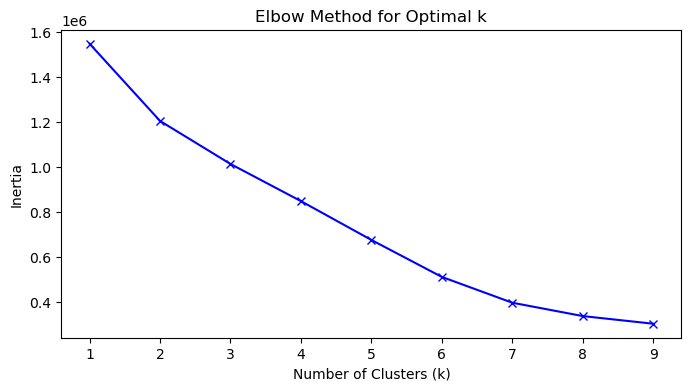

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Find the optimal number of clusters using Inertia (The Elbow Method)
inertia = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca) # PCA-transformed data from earlier
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

## 5. Clustering

In [6]:
best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_final['cluster'] = kmeans.fit_predict(X_pca)

## 6. Cluster Profiling (Weighted Analysis)

In [7]:
def get_weighted_mean(data, col, weight_col='weight'):
    return (data[col] * data[weight_col]).sum() / data[weight_col].sum()

profile_results = []

for c in range(best_k):
    cluster_data = df_final[df_final['cluster'] == c]
    
    profile = {
        'Cluster': c,
        'Size (Weighted)': cluster_data['weight'].sum(),
        'Avg_Income_Prob': get_weighted_mean(cluster_data, 'income_probability'),
        'Actual_High_Income_Rate': get_weighted_mean(cluster_data, 'income_target'),
        'Avg_Age': get_weighted_mean(cluster_data, 'age'),
        'Avg_Weeks_Worked': get_weighted_mean(cluster_data, 'weeks worked in year'),
        'Top_Occupation': cluster_data['major occupation code'].mode()[0],
        'Avg_Education': get_weighted_mean(cluster_data, 'education'),
        'Top_Industry': cluster_data['major industry code'].mode()[0] 
    }
    profile_results.append(profile)

df_profile = pd.DataFrame(profile_results)
display(df_profile)

,Cluster,Size (Weighted),Avg_Income_Prob,Actual_High_Income_Rate,Avg_Age,Avg_Weeks_Worked,Top_Occupation,Avg_Education,Top_Industry
0,0,1.261698e+08,0.161771,0.089450,38.132163,46.616536,0,11.046487,19
1,1,1.659109e+08,0.007670,0.003011,28.128800,1.232395,6,9.013936,14
2,2,2.827499e+07,0.378321,0.262413,51.836485,32.460666,6,11.413064,14
3,3,7.036740e+06,0.384977,0.302425,43.785959,41.530973,6,10.915873,14
4,4,1.985347e+07,0.084914,0.045736,36.218120,44.968459,0,10.793621,19


### Group Mapping for Presentation

In [8]:
cluster_name_map = {
    3: "Premium Target Segment",
    2: "High-Value Mature Segment",
    0: "Upsell Opportunity Segment",
    4: "Low ROI Segment",
    1: "Avoid Segment"
}

df_final['Segment'] = df_final['cluster'].map(cluster_name_map)

In [9]:
segment_colors = {
    "Premium Target Segment": "#1b9e77",
    "High-Value Mature Segment": "#66a61e",
    "Upsell Opportunity Segment": "#7570b3",
    "Low ROI Segment": "#e6ab02",
    "Avoid Segment": "#d95f02"
}

In [10]:
profile_results = []

for c in range(best_k):
    cluster_data = df_final[df_final['cluster'] == c]
    
    profile = {
        'Cluster': c,
        'Segment': cluster_name_map[c],
        'Size (Weighted)': cluster_data['weight'].sum(),
        'Avg_Income_Prob': get_weighted_mean(cluster_data, 'income_probability'),
        'Actual_High_Income_Rate': get_weighted_mean(cluster_data, 'income_target'),
        'Avg_Age': get_weighted_mean(cluster_data, 'age'),
        'Avg_Weeks_Worked': get_weighted_mean(cluster_data, 'weeks worked in year'),
        'Top_Occupation': cluster_data['major occupation code'].mode()[0],
        'Avg_Education': get_weighted_mean(cluster_data, 'education'),
        'Top_Industry': cluster_data['major industry code'].mode()[0] 
    }
    profile_results.append(profile)

df_profile = pd.DataFrame(profile_results)
display(df_profile.sort_values("Avg_Income_Prob", ascending=False))

,Cluster,Segment,Size (Weighted),Avg_Income_Prob,Actual_High_Income_Rate,Avg_Age,Avg_Weeks_Worked,Top_Occupation,Avg_Education,Top_Industry
3,3,Premium Target Segment,7.036740e+06,0.384977,0.302425,43.785959,41.530973,6,10.915873,14
2,2,High-Value Mature Segment,2.827499e+07,0.378321,0.262413,51.836485,32.460666,6,11.413064,14
0,0,Upsell Opportunity Segment,1.261698e+08,0.161771,0.089450,38.132163,46.616536,0,11.046487,19
4,4,Low ROI Segment,1.985347e+07,0.084914,0.045736,36.218120,44.968459,0,10.793621,19
1,1,Avoid Segment,1.659109e+08,0.007670,0.003011,28.128800,1.232395,6,9.013936,14


## 7. Clustering Result Visualization

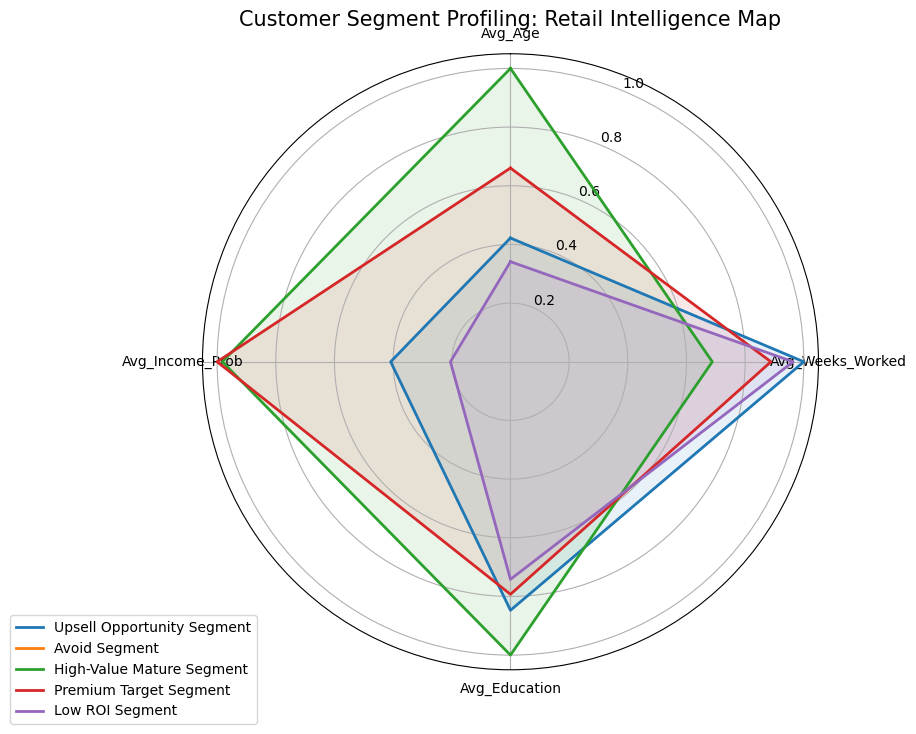

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

features = ['Avg_Age', 'Avg_Weeks_Worked', 'Avg_Education', 'Avg_Income_Prob']
df_radar = df_profile[features]

df_radar_norm = (df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())

categories = features
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

colors = ['#7570b3', '#d95f02', '#66a61e', '#1b9e77', '#e6ab02'] # 설정하신 segment_colors 기반
for i in range(len(df_radar_norm)):
    values = df_radar_norm.iloc[i].values.flatten().tolist()
    values += values[:1]
    segment_name = df_profile.iloc[i]['Segment']
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=segment_name)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
plt.title("Customer Segment Profiling: Retail Intelligence Map", size=15, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

/var/folders/71/ftlxnzqj3rg_cjsh84hfpzkc0000gn/T/ipykernel_4632/2062779027.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


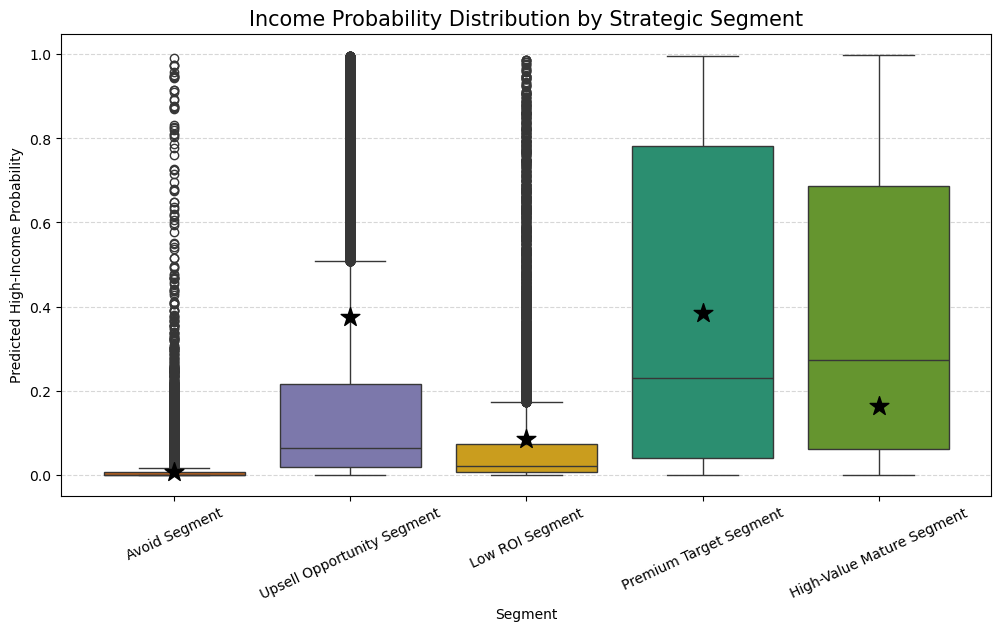

In [15]:
plt.figure(figsize=(12, 6))

sns.boxplot(
    x='Segment',
    y='income_probability',
    data=df_final,
    palette=segment_colors
)

means = df_final.groupby('Segment')['income_probability'].mean()

for i, segment in enumerate(means.index):
    plt.scatter(
        i,
        means[segment],
        color='black',
        marker='*',
        s=200,
        zorder=10
    )

plt.title('Income Probability Distribution by Strategic Segment', fontsize=15)
plt.xticks(rotation=25)
plt.ylabel('Predicted High-Income Probability')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 8. Segment-Level Lift Analysis

In [17]:
overall_high_income_rate = get_weighted_mean(df_final, 'income_target')

analysis_list = []

for i in range(best_k):
    cluster_data = df_final[df_final['cluster'] == i]
    cluster_high_income_rate = get_weighted_mean(cluster_data, 'income_target')
    lift = cluster_high_income_rate / overall_high_income_rate
    
    analysis_list.append({
        'Segment': cluster_name_map[i],
        'Cluster': i,
        'High-Income Rate (%)': cluster_high_income_rate * 100,
        'Cluster Size (Weighted)': cluster_data['weight'].sum(),
        'Lift': lift,
        'Targeting Efficiency': 'High' if lift > 2 else ('Medium' if lift > 1 else 'Low')
    })

df_biz_value = pd.DataFrame(analysis_list)
display(df_biz_value.sort_values(by='Lift', ascending=False))

,Segment,Cluster,High-Income Rate (%),Cluster Size (Weighted),Lift,Targeting Efficiency
3,Premium Target Segment,3,30.242456,7.036740e+06,4.721664,High
2,High-Value Mature Segment,2,26.241250,2.827499e+07,4.096968,High
0,Upsell Opportunity Segment,0,8.945015,1.261698e+08,1.396558,Medium
4,Low ROI Segment,4,4.573626,1.985347e+07,0.714066,Low
1,Avoid Segment,1,0.301075,1.659109e+08,0.047006,Low


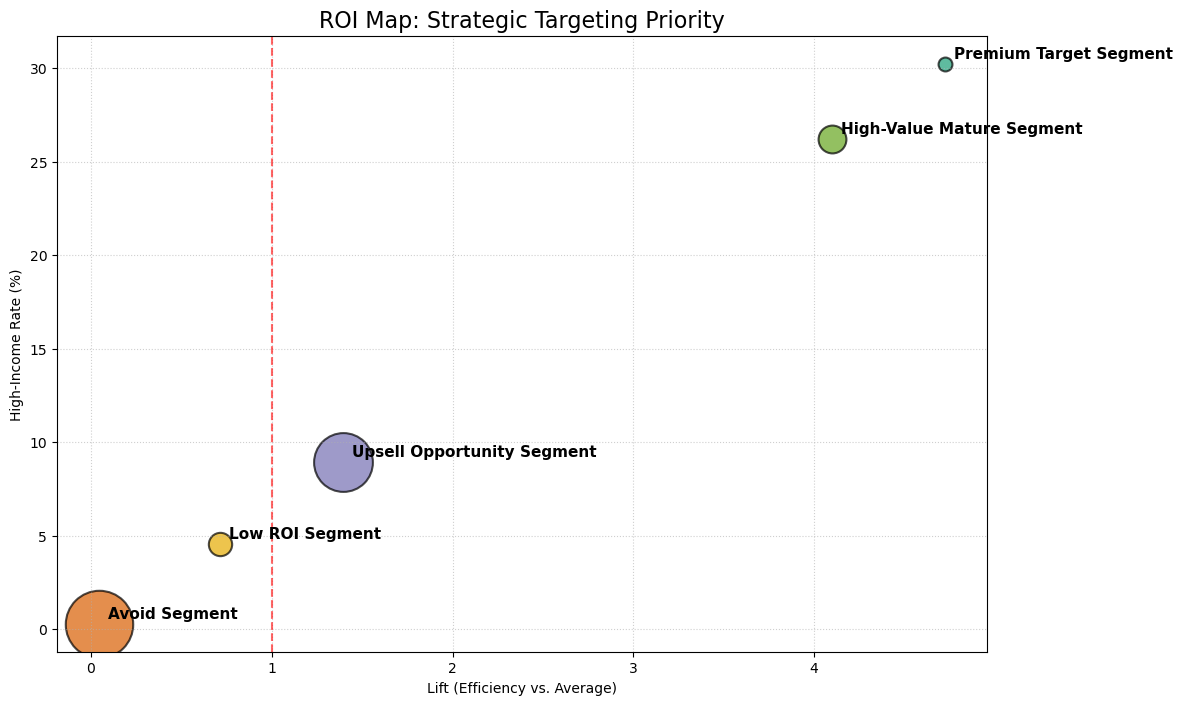

In [19]:
raw_sizes = df_biz_value['Cluster Size (Weighted)']
bubble_size = (raw_sizes / raw_sizes.min()) * 100 

plt.figure(figsize=(12, 8))

for i in range(len(df_biz_value)):
    
    segment = df_biz_value['Segment'][i]
    
    plt.scatter(
        df_biz_value['Lift'][i],
        df_biz_value['High-Income Rate (%)'][i],
        s=bubble_size[i],
        color=segment_colors[segment],
        alpha=0.7,
        edgecolors="black",
        linewidth=1.5
    )
    
    plt.text(
        df_biz_value['Lift'][i] + 0.05,
        df_biz_value['High-Income Rate (%)'][i] + 0.3,
        segment,
        fontsize=11,
        fontweight='bold'
    )

plt.axvline(x=1, color='red', linestyle='--', alpha=0.6)
plt.title('ROI Map: Strategic Targeting Priority', fontsize=16)
plt.xlabel('Lift (Efficiency vs. Average)')
plt.ylabel('High-Income Rate (%)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()